In [1]:
import os 
cwd = os.getcwd()

os.chdir('../')
cwd = os.getcwd()
print(cwd)

os.chdir('./code/')
cwd = os.getcwd()
print(cwd)

import pandas as pd 
import numpy as np 
import seaborn as sns

import pickle 
import logging


# from config.config import SQLQuery
# querySno = SQLQuery('snowflake')

/Users/shashankgupta/Documents/code/git_project/plaid_credit
/Users/shashankgupta/Documents/code/git_project/plaid_credit/Code


In [2]:
from preprocess import Convert,MissingValues,Outlier,FeatureSelection
from feature_transformation import Scaler,Transform,Selection
from model_building import split_test_train, feature_encoding, classification_models
from model_evaluations import model_metrics, feature_importance, probability_bins, cross_validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

from statsmodels.stats.outliers_influence import variance_inflation_factor

# object initiation 
tf = Transform()
sel = Selection()
ft = FeatureSelection()
cv = Convert()
mv = MissingValues()
ot = Outlier()

# set seed
seed = 9

In [3]:
corr_arr = 0.4 # person correlation coefficient # change it to 0.5
vif_arr = 5 # vif coefficient
features_arr = 10 # total number of features to be selected from backward feature selection
iv_upper_limit = 0.5 # upper threshold of iv # change it to 0.6
iv_lower_limit = 0.02 # lower threshold of iv

In [4]:
df_raw = pd.read_pickle('/Users/shashankgupta/Documents/code/git_project/plaid_credit/data/final_dataset.pkl')
df_raw.shape

(646, 243)

In [5]:
df_raw.columns

Index(['business_id', 'lending_business_id', 'decision_date', 'drawn_flag',
       'everDPD_15', 'fico_score', 'target', 'loans_flag', 'payroll_flag',
       'pos_flag',
       ...
       'sum_credits_grt_1500_6M', 'ratio_credits_lessthan_100_1M_3M',
       'ratio_credits_lessthan_100_1M_6M', 'ratio_credits_grt_500_1M_3M',
       'ratio_credits_grt_500_1M_6M', 'ratio_credits_grt_1500_1M_3M',
       'ratio_credits_grt_1500_1M_6M', 'txn_each_mth_flag',
       'txn_grt_100_each_mth_flag', 'txn_flag'],
      dtype='object', length=243)

In [6]:
df_raw['txn_flag'].value_counts()

txn_flag
1.0    637
0.0      9
Name: count, dtype: int64

In [7]:
df_raw = df_raw[df_raw['txn_flag']==1]
df_raw.shape

(637, 243)

In [8]:
df_raw = df_raw.drop(['business_id', 'lending_business_id','decision_date','drawn_flag', 'everDPD_15', 'fico_score','txn_flag'], axis=1)
df_raw.shape

(637, 236)

In [70]:
df_raw[['credit_size_3M', 'median_credit_amt_3M', 'stddev_credit_amt_3M','target']]

,credit_size_3M,median_credit_amt_3M,stddev_credit_amt_3M,target
0,1330.152857,140.000,3265.835892,0
1,780.922941,500.000,869.793709,0
2,6823.550000,13647.100,NaN,0
3,3442.870769,4249.995,2372.763887,0
4,833.333333,1250.000,353.553391,0
...,...,...,...,...
641,615.698250,200.000,1151.705632,0
642,1133.936857,933.665,1036.449283,0
643,9604.730000,14887.440,7583.423561,1
644,7.240000,10.760,5.110669,1


In [9]:
## train-test split

# train test split
x_train, y_train, x_test, y_test = split_test_train(df_raw, target_column='target', test_size=0.3, random_state=seed)
print(f'{x_train.shape = }', '|' ,f'{y_train.shape = }', '|' ,f'{x_test.shape = }', '|' ,f'{y_test.shape = }')


# copy to df
df = x_train.copy(deep=True)

x_train.shape = (445, 235) | y_train.shape = (445,) | x_test.shape = (192, 235) | y_test.shape = (192,)


In [10]:
# get constant features
def get_const_features(df):
    const_list = []
    for col in df.columns: 
        if (len(df[col].unique())==1):
            const_list.append(col)
    return(const_list)

# remove constant features
const_list = get_const_features(df)
df = df.drop(columns=const_list)
df.shape

(445, 235)

In [11]:
# get quasi-constant features
def get_quasi_const_features(df, threshold=0.01):
    qconst_list = []
    for col in df.columns: 
        if (df[col].var() <= threshold):
            qconst_list.append(col)
    return(qconst_list)

# remove constant features
qconst_list = get_quasi_const_features(df, threshold=0.01)
df = df.drop(columns=qconst_list)
df.shape

(445, 226)

In [12]:
# view missing values
def missing_value(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_val_df = pd.DataFrame({'percent_missing': percent_missing})
    missing_val_df.sort_values(by='percent_missing', ascending=False, inplace=True)
    return missing_val_df

missing_value(df)

,percent_missing
stddev_loans_amt_1M,96.179775
stddev_ecom_amt_1M,93.033708
stddev_loans_amt_3M,91.235955
ratio_stddev_loan_amt_3M_6M,91.235955
loans_amt_1M,91.011236
...,...
third_party_flag,0.000000
ecom_flag,0.000000
pos_flag,0.000000
txn_each_mth_flag,0.000000


In [13]:
t = missing_value(df)
drop_cols = list(t[t['percent_missing']>80].index)
df.drop(drop_cols,axis=1,inplace=True)
df.shape

(445, 187)

In [14]:
# Treating missing values
df = df.fillna(0)

In [15]:
# get boolean columns
def findbool(df):
    bool_arr = []
    for col in df.columns: 
        if (len(df[col].unique())<=2):
            bool_arr.append(col)
    return(bool_arr)

# get datatypes frequency
def get_datatypes_freq(df):
    type_dct = {str(k): list(v) for k, v in df.groupby(df.dtypes, axis=1)}
    type_dct_info = {k: len(v) for k, v in type_dct.items()}
    return type_dct, type_dct_info

type_dct, type_dct_info = get_datatypes_freq(df)
print(type_dct_info)

bool_col_list = findbool(df)
print(len(bool_col_list))

type_dct, type_dct_info = get_datatypes_freq(df)
col_list = (type_dct['float64'])
col_list_excpt_bool = [column for column in col_list if column not in bool_col_list]
print(len(col_list_excpt_bool))

{'float64': 187}
10
177


In [16]:
## iv_woe

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [17]:
# remove features on basis of IV
# y_train.reset_index(drop=True, inplace=True)
df['target'] = y_train
df['target'] = df['target'].astype(float)
temp = df.copy()

t1, t2 = iv_woe(temp[np.append(col_list_excpt_bool,['target'])], 'target', bins=5, show_woe=False)
feature_list = list(t1[ (t1['IV']<iv_upper_limit) & (t1['IV']>iv_lower_limit) ]['Variable'].values)
len(feature_list)

Information value of total_credit_count_1M is 0.046417
Information value of total_credit_count_3M is 0.123842
Information value of total_credit_count_6M is 0.106814
Information value of total_credit_amt_1M is 0.039476
Information value of total_credit_amt_3M is 0.087181
Information value of total_credit_amt_6M is 0.046794
Information value of credit_size_1M is 0.117904
Information value of credit_size_3M is 0.286985
Information value of credit_size_6M is 0.244407
Information value of stddev_credit_amt_1M is 0.142908
Information value of median_credit_amt_1M is 0.14747
Information value of stddev_credit_amt_3M is 0.151783
Information value of median_credit_amt_3M is 0.195674
Information value of stddev_credit_amt_6M is 0.090132
Information value of median_credit_amt_6M is 0.254997
Information value of ratio_stddev_credit_amt_1M_6M is 0.042563
Information value of ratio_stddev_credit_amt_1M_3M is 0.016118
Information value of ratio_median_credit_amt_1M_6M is 0.056231
Information value of

128

In [18]:
# view correlation
corr_df, subset_df = sel.get_correlated_features(df, feature_list, thresh=corr_arr)
corr_df


# remove correlated features
feature_list = sel.corr_iter(df, np.array(feature_list), thresh=corr_arr)
feature_list = list(feature_list)
len(feature_list)

28

In [73]:
corr_df[corr_df['feature_1'] == 'stddev_credit_amt_3M'].to_clipboard()

In [19]:
# get feature list after itaerative VIF elimination
def vif_iter(df, iv, threshold=10):
    vif_data = pd.DataFrame()
    vif_data["feature"] = iv
    vif_data["VIF"] = [variance_inflation_factor(df[iv].values, i) for i in range(len(iv))]
    if len(vif_data[vif_data['VIF'] == np.inf]) > 0:
        feature = vif_data[vif_data['VIF'] == np.inf]['feature'].iloc[0]
        iv.remove(feature)
        vif_iter(df, iv, threshold)
    elif len(vif_data[vif_data['VIF'] > threshold]) > 0:
        feature = vif_data.sort_values(by='VIF', ascending=False)['feature'].iloc[0]
        iv.remove(feature)
        vif_iter(df, iv, threshold)
    vif_data = pd.DataFrame()
    vif_data["feature"] = iv
    vif_data["VIF"] = [variance_inflation_factor(df[iv].values, i) for i in range(len(iv))]
    return iv, vif_data

feature_list, vif_df = vif_iter(df, feature_list, threshold=vif_arr)
len(feature_list)

28

In [20]:
# Backward feature elimination
feat_list = ft.backward_feature_selection(df[feature_list], y_train, num_features=features_arr)
feat_list

['stddev_credit_amt_3M',
 'median_shops_amt_6M',
 'stddev_payroll_amt_3M',
 'shops_count_3M',
 'pos_amt_1M',
 'ratio_stddev_third_party_amt_3M_6M',
 'ratio_pos_size_credit_size_1M',
 'count_credits_lessthan_100_6M',
 'count_credits_grt_500_6M',
 'ratio_credits_grt_1500_1M_3M']

In [21]:
## optimal binning woe

import optbinning as optb
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.binning.binning_statistics import BinningTable

df_temp = df[feat_list].copy()
df_temp['target'] = df['target']

(CVXPY) Jun 30 01:02:56 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 30 01:02:56 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


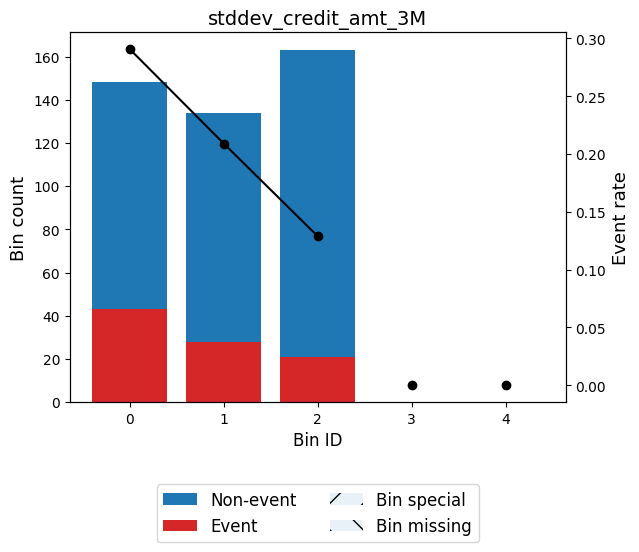

In [65]:
# 1
Xt= df_temp['stddev_credit_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='stddev_credit_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_stddev_credit_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [66]:
ob_stddev_credit_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 578.24)",148,0.332584,105,43,0.290541,-0.451919,0.076800,0.009519
1,"[578.24, 1274.05)",134,0.301124,106,28,0.208955,-0.013445,0.000055,0.000007
2,"[1274.05, inf)",163,0.366292,142,21,0.128834,0.566625,0.098596,0.012162
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.175450,0.021688


In [24]:
# 1
# Var tranform
transformed_vars = df[feat_list].copy()

# transform
col         = 'stddev_credit_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 578), 
                (transformed_vars[col] >= 578 ) & (transformed_vars[col] < 1274), 
                (transformed_vars[col] >= 1274) & (transformed_vars[col] < 7646),
                transformed_vars[col] >= 7646 ]

choices     = [0.090405,-0.551449,-0.013445, 0.40452,1.951157]
    
transformed_vars["stddev_credit_amt_3M"] = np.select(conditions, choices, default=np.nan)

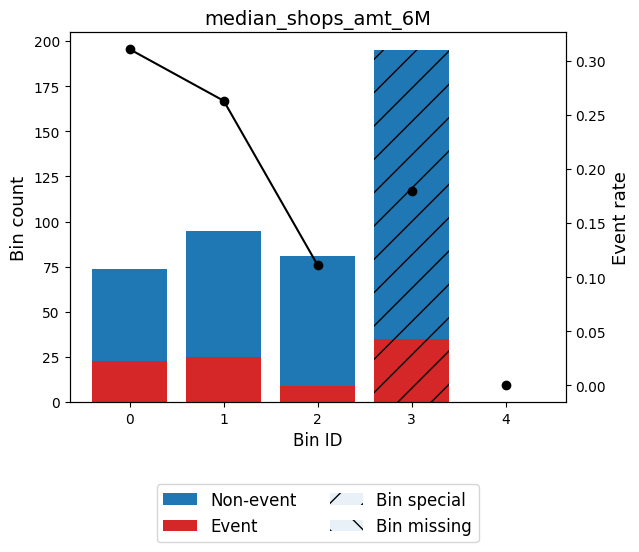

In [25]:
# 2
Xt= df_temp['median_shops_amt_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='median_shops_amt_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_median_shops_amt_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [26]:
ob_median_shops_amt_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 108.95)",74,0.166292,51,23,0.310811,-0.548348,0.057864,0.007144
1,"[108.95, 953.75)",95,0.213483,70,25,0.263158,-0.31506,0.023138,0.002880
2,"[953.75, inf)",81,0.182022,72,9,0.111111,0.734762,0.077988,0.009535
3,Special,195,0.438202,160,35,0.179487,0.175146,0.012755,0.001592
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.171744,0.021151


In [27]:
# 2
# transform
col         = 'median_shops_amt_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 109), 
                (transformed_vars[col] >= 109 ) & (transformed_vars[col] < 954),
                transformed_vars[col] >= 954 ]

choices     = [0.175146,-0.548348,-0.31506, 0.734762]
    
transformed_vars["median_shops_amt_6M"] = np.select(conditions, choices, default=np.nan)

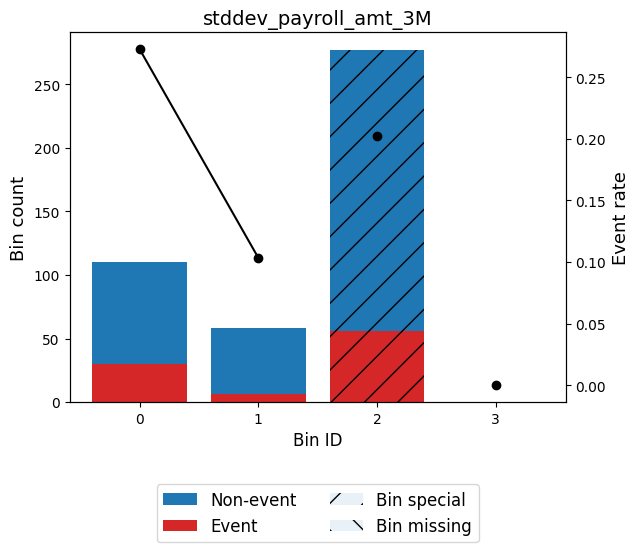

In [28]:
# 3
Xt= df_temp['stddev_payroll_amt_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='stddev_payroll_amt_3M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_stddev_payroll_amt_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [29]:
ob_stddev_payroll_amt_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 900.69)",110,0.247191,80,30,0.272727,-0.36385,0.036188,0.004499
1,"[900.69, inf)",58,0.130337,52,6,0.103448,0.814805,0.066888,0.008137
2,Special,277,0.622472,221,56,0.202166,0.028132,0.000489,0.000061
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.103565,0.012697


In [30]:
# 3
# transform
col         = 'stddev_payroll_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 901),
                transformed_vars[col] >= 901 ]

choices     = [0.028132,-0.36385,0.814805]
    
transformed_vars["stddev_payroll_amt_3M"] = np.select(conditions, choices, default=np.nan)

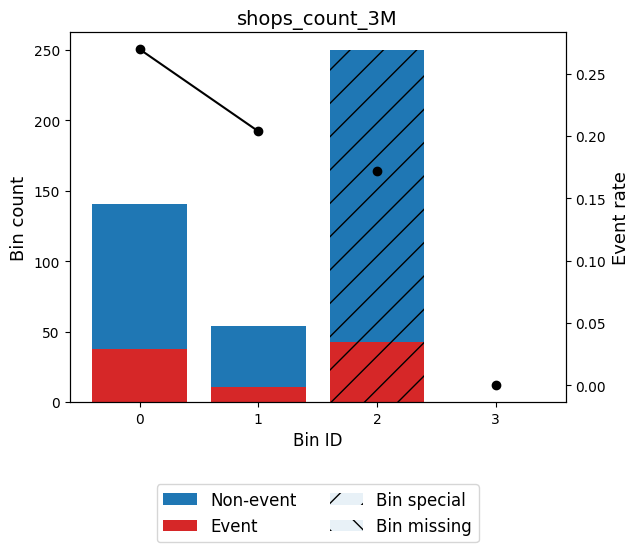

In [31]:
# 4
Xt= df_temp['shops_count_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='shops_count_3M', dtype="numerical", max_n_prebins=3, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_shops_count_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [32]:
ob_shops_count_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 4.50)",141,0.316854,103,38,0.269504,-0.347537,0.042142,0.005241
1,"[4.50, inf)",54,0.121348,43,11,0.203704,0.018625,0.000042,0.000005
2,Special,250,0.561798,207,43,0.172000,0.226839,0.026996,0.003367
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.069180,0.008614


In [33]:
# 4
# transform
col         = 'shops_count_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 4.5),
                transformed_vars[col] >= 4.5 ]

choices     = [0.226839,-0.347537,0.018625]
    
transformed_vars["shops_count_3M"] = np.select(conditions, choices, default=np.nan)

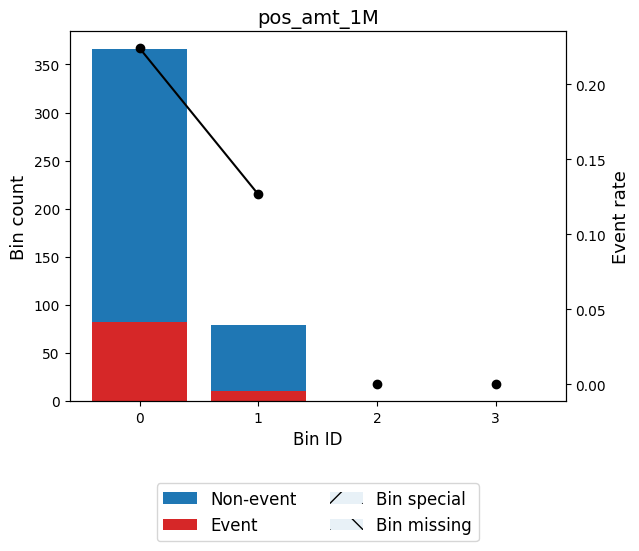

In [34]:
# 5
Xt= df_temp['pos_amt_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='pos_amt_1M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_pos_amt_1M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [35]:
ob_pos_amt_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1780.00)",366,0.822472,284,82,0.224044,-0.102424,0.008888,0.001110
1,"[1780.00, inf)",79,0.177528,69,10,0.126582,0.586842,0.050921,0.006275
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.059809,0.007386


In [36]:
# 5
# transform
col         = 'pos_amt_1M'
conditions  = [ transformed_vars[col] < 1780,
                transformed_vars[col] >= 1780 ]

choices     = [-0.102424,0.586842]
    
transformed_vars["pos_amt_1M"] = np.select(conditions, choices, default=np.nan)

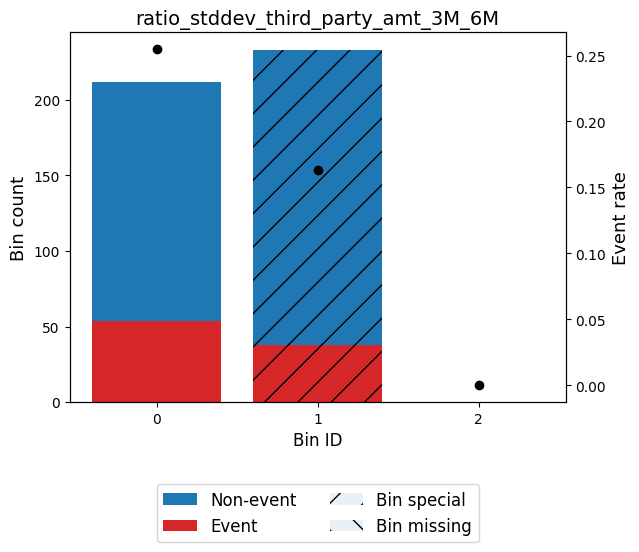

In [37]:
# 6
Xt= df_temp['ratio_stddev_third_party_amt_3M_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_stddev_third_party_amt_3M_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_stddev_third_party_amt_3M_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [38]:
ob_ratio_stddev_third_party_amt_3M_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",212,0.476404,158,54,0.254717,-0.271068,0.037777,0.004708
1,Special,233,0.523596,195,38,0.163090,0.290734,0.040518,0.005047
2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.078295,0.009755


In [39]:
# 6
# transform
col         = 'ratio_stddev_third_party_amt_3M_6M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.290734,-0.271068]
    
transformed_vars["ratio_stddev_third_party_amt_3M_6M"] = np.select(conditions, choices, default=np.nan)

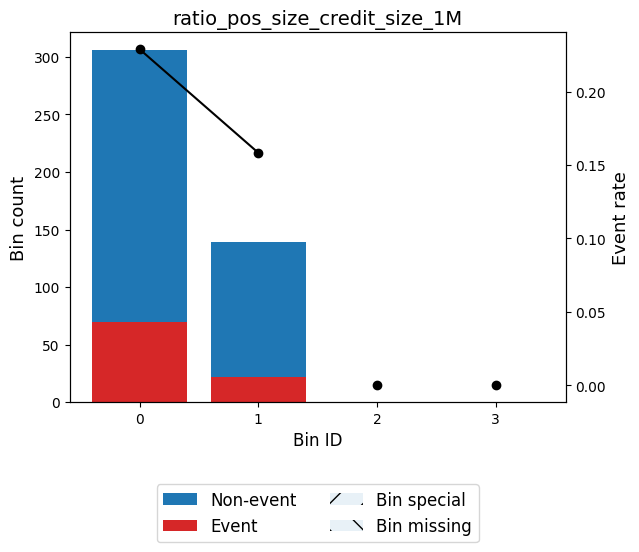

In [40]:
# 7
Xt= df_temp['ratio_pos_size_credit_size_1M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_pos_size_credit_size_1M', dtype="numerical", max_n_prebins=2, monotonic_trend='descending')
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_pos_size_credit_size_1M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [41]:
ob_ratio_pos_size_credit_size_1M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.27)",306,0.68764,236,70,0.228758,-0.129343,0.011940,0.001491
1,"[0.27, inf)",139,0.31236,117,22,0.158273,0.326452,0.030136,0.003750
2,Special,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.00000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.00000,353,92,0.206742,,0.042076,0.005242


In [42]:
# 7
# transform
col         = 'ratio_pos_size_credit_size_1M'
conditions  = [ transformed_vars[col] < 0.27,
                transformed_vars[col] >= 0.27 ]

choices     = [-0.129343,0.326452]
    
transformed_vars["ratio_pos_size_credit_size_1M"] = np.select(conditions, choices, default=np.nan)

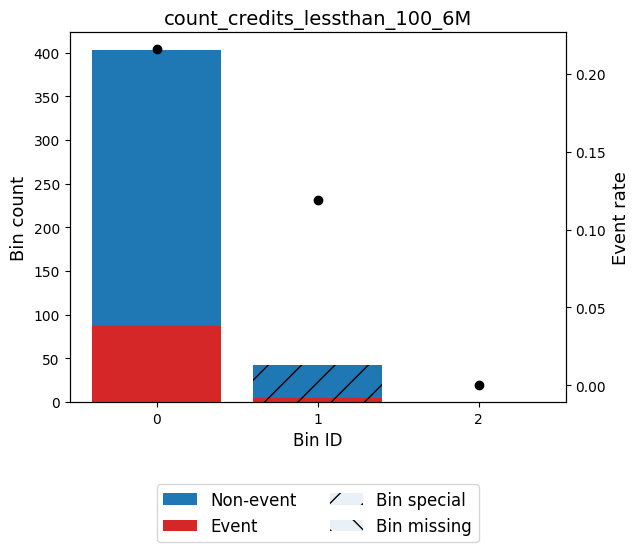

In [43]:
# 8
Xt= df_temp['count_credits_lessthan_100_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='count_credits_lessthan_100_6M', dtype="numerical", max_n_prebins=2, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_count_credits_lessthan_100_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [44]:
ob_count_credits_lessthan_100_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",403,0.905618,316,87,0.215881,-0.054845,0.002768,0.000346
1,Special,42,0.094382,37,5,0.119048,0.656801,0.033147,0.004071
2,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.035915,0.004416


In [45]:
# 8
# transform
col         = 'count_credits_lessthan_100_6M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.656801,-0.054845]
    
transformed_vars["count_credits_lessthan_100_6M"] = np.select(conditions, choices, default=np.nan)

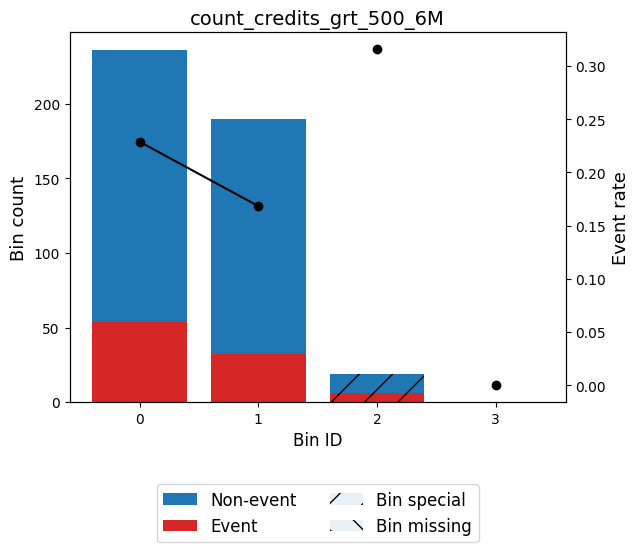

In [46]:
# 9
Xt= df_temp['count_credits_grt_500_6M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='count_credits_grt_500_6M', dtype="numerical", max_n_prebins=4, monotonic_trend='descending',special_codes=[0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_count_credits_grt_500_6M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [47]:
ob_count_credits_grt_500_6M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 22.50)",236,0.530337,182,54,0.228814,-0.129657,0.009254,0.001156
1,"[22.50, inf)",190,0.426966,158,32,0.168421,0.25218,0.025159,0.003137
2,Special,19,0.042697,13,6,0.315789,-0.57149,0.016225,0.002001
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.050638,0.006293


In [48]:
# 9
# transform
col         = 'count_credits_grt_500_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 22.5),
                transformed_vars[col] >= 22.5 ]

choices     = [-0.57149,-0.129657,0.25218]
    
transformed_vars["count_credits_grt_500_6M"] = np.select(conditions, choices, default=np.nan)

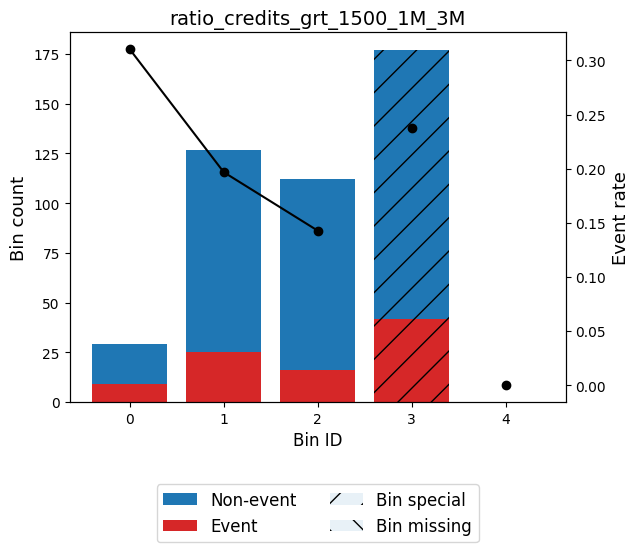

In [49]:
# 10
Xt= df_temp['ratio_credits_grt_1500_1M_3M']
yt = df_temp['target'].astype(int)

optb = OptimalBinning(name='ratio_credits_grt_1500_1M_3M', dtype="numerical", max_n_prebins=5, monotonic_trend='descending',special_codes = [0])
optb.fit(Xt, yt)  

Xt_binned = optb.transform(Xt)

ob_ratio_credits_grt_1500_1M_3M = optb.binning_table.build()

optb.binning_table.plot(metric="event_rate")

In [50]:
ob_ratio_credits_grt_1500_1M_3M

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.17)",29,0.065169,20,9,0.310345,-0.546172,0.022485,0.002776
1,"[0.17, 0.34)",127,0.285393,102,25,0.196850,0.061418,0.001057,0.000132
2,"[0.34, inf)",112,0.251685,96,16,0.142857,0.44708,0.043832,0.005434
3,Special,177,0.397753,135,42,0.237288,-0.177074,0.013119,0.001638
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,445,1.000000,353,92,0.206742,,0.080494,0.009980


In [51]:
# 10
# transform
col         = 'ratio_credits_grt_1500_1M_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 0.17),
                (transformed_vars[col] >= 0.17 ) & (transformed_vars[col] < 0.34),
                transformed_vars[col] >= 0.34 ]

choices     = [-0.177074,-0.546172,0.061418,0.44708]
    
transformed_vars["ratio_credits_grt_1500_1M_3M"] = np.select(conditions, choices, default=np.nan)

In [52]:
transformed_vars

,stddev_credit_amt_3M,median_shops_amt_6M,stddev_payroll_amt_3M,shops_count_3M,pos_amt_1M,ratio_stddev_third_party_amt_3M_6M,ratio_pos_size_credit_size_1M,count_credits_lessthan_100_6M,count_credits_grt_500_6M,ratio_credits_grt_1500_1M_3M
408,-0.551449,0.175146,0.028132,0.226839,-0.102424,0.290734,-0.129343,0.656801,-0.129657,-0.177074
108,-0.013445,-0.548348,-0.363850,-0.347537,-0.102424,-0.271068,-0.129343,-0.054845,0.252180,0.061418
613,-0.013445,-0.548348,0.028132,0.226839,-0.102424,-0.271068,-0.129343,-0.054845,-0.129657,0.061418
101,-0.013445,-0.548348,0.814805,-0.347537,-0.102424,-0.271068,0.326452,-0.054845,-0.129657,0.061418
484,1.951157,0.175146,0.814805,0.226839,-0.102424,0.290734,-0.129343,0.656801,0.252180,-0.177074
...,...,...,...,...,...,...,...,...,...,...
170,-0.551449,-0.548348,0.028132,0.018625,-0.102424,-0.271068,-0.129343,-0.054845,-0.129657,-0.177074
157,0.404520,-0.315060,0.814805,-0.347537,-0.102424,-0.271068,-0.129343,-0.054845,0.252180,0.447080
36,-0.013445,0.175146,0.028132,0.226839,-0.102424,0.290734,-0.129343,-0.054845,-0.129657,-0.177074
5,-0.551449,-0.548348,-0.363850,-0.347537,-0.102424,-0.271068,-0.129343,-0.054845,-0.129657,-0.177074


#### Model fitting

In [53]:
# copy vars
X_train = transformed_vars.copy()

# hyperparameters
params_log_reg = {'penalty': 'l2',
                  'random_state': seed,
                  'solver': 'liblinear',
                  'class_weight': 'balanced'}

# model fit
logreg_model = classification_models(X_train[feat_list], y_train, params_log_reg, models=['log_reg'])

In [54]:
# train cv scores
cv_scores = cross_validation(logreg_model, X_train[feat_list], y_train, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.71 0.71 0.64]
Mean of CV Scores - 0.69


In [55]:
# Feature importance
feat_imp = feature_importance(logreg_model, X_train[feat_list], show_plot=True)

feat_imp.sort_values(by='importance', ascending=False)

,importance
stddev_payroll_amt_3M,-0.365166
pos_amt_1M,-0.435688
ratio_credits_grt_1500_1M_3M,-0.444098
median_shops_amt_6M,-0.525271
stddev_credit_amt_3M,-0.676900
count_credits_lessthan_100_6M,-0.679057
count_credits_grt_500_6M,-0.818477
shops_count_3M,-0.875878
ratio_stddev_third_party_amt_3M_6M,-1.076342
ratio_pos_size_credit_size_1M,-1.089412


In [56]:
# binning variable transform
x_test.fillna(0, inplace=True)

transformed_vars = x_test[feat_list]

In [57]:
# 1
# transform
col         = 'stddev_credit_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 578), 
                (transformed_vars[col] >= 578 ) & (transformed_vars[col] < 1274), 
                (transformed_vars[col] >= 1274) & (transformed_vars[col] < 7646),
                transformed_vars[col] >= 7646 ]

choices     = [0.090405,-0.551449,-0.013445, 0.40452,1.951157]
    
transformed_vars["stddev_credit_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 2
# transform
col         = 'median_shops_amt_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 109), 
                (transformed_vars[col] >= 109 ) & (transformed_vars[col] < 954),
                transformed_vars[col] >= 954 ]

choices     = [0.175146,-0.548348,-0.31506, 0.734762]
    
transformed_vars["median_shops_amt_6M"] = np.select(conditions, choices, default=np.nan)

# 3
# transform
col         = 'stddev_payroll_amt_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 901),
                transformed_vars[col] >= 901 ]

choices     = [0.028132,-0.36385,0.814805]
    
transformed_vars["stddev_payroll_amt_3M"] = np.select(conditions, choices, default=np.nan)

# 4
# transform
col         = 'shops_count_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 4.5),
                transformed_vars[col] >= 4.5 ]

choices     = [0.226839,-0.347537,0.018625]
    
transformed_vars["shops_count_3M"] = np.select(conditions, choices, default=np.nan)

# 5
# transform
col         = 'pos_amt_1M'
conditions  = [ transformed_vars[col] < 1780,
                transformed_vars[col] >= 1780 ]

choices     = [-0.102424,0.586842]
    
transformed_vars["pos_amt_1M"] = np.select(conditions, choices, default=np.nan)

# 6
# transform
col         = 'ratio_stddev_third_party_amt_3M_6M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.290734,-0.271068]
    
transformed_vars["ratio_stddev_third_party_amt_3M_6M"] = np.select(conditions, choices, default=np.nan)

# 7
# transform
col         = 'ratio_pos_size_credit_size_1M'
conditions  = [ transformed_vars[col] < 0.27,
                transformed_vars[col] >= 0.27 ]

choices     = [-0.129343,0.326452]
    
transformed_vars["ratio_pos_size_credit_size_1M"] = np.select(conditions, choices, default=np.nan)

# 8
# transform
col         = 'count_credits_lessthan_100_6M'
conditions  = [ transformed_vars[col] <= 0,
                transformed_vars[col] > 0 ]

choices     = [0.656801,-0.054845]
    
transformed_vars["count_credits_lessthan_100_6M"] = np.select(conditions, choices, default=np.nan)


# 9
# transform
col         = 'count_credits_grt_500_6M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 22.5),
                transformed_vars[col] >= 22.5 ]

choices     = [-0.57149,-0.129657,0.25218]
    
transformed_vars["count_credits_grt_500_6M"] = np.select(conditions, choices, default=np.nan)


# 10
# transform
col         = 'ratio_credits_grt_1500_1M_3M'
conditions  = [ transformed_vars[col] <= 0, 
                (transformed_vars[col] > 0 ) & (transformed_vars[col] < 0.17),
                (transformed_vars[col] >= 0.17 ) & (transformed_vars[col] < 0.34),
                transformed_vars[col] >= 0.34 ]

choices     = [-0.177074,-0.546172,0.061418,0.44708]
    
transformed_vars["ratio_credits_grt_1500_1M_3M"] = np.select(conditions, choices, default=np.nan)


In [58]:
# copy
X_test = transformed_vars.copy()

In [59]:
# test cv scores
cv_scores = cross_validation(logreg_model, X_test[feat_list], y_test, scoring='roc_auc', folds=3, seed=seed)
print('CV Scores -',np.round(cv_scores, 2))
print('Mean of CV Scores -',np.round(np.mean(cv_scores),2))

CV Scores - [0.68 0.68 0.59]
Mean of CV Scores - 0.65


In [60]:
## Model Evaluation - KS & ROC AUC

def ks(target=None, prob=None):
    data = pd.DataFrame()
    data['y'] = target
    data['y'] = data['y'].astype(float)
    data['p'] = prob
    data['y0'] = 1- data['y']
    data['bucket'] = pd.qcut(data['p'], 5)
    grouped = data.groupby('bucket', as_index=False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()['p']
    kstable['max_prob'] = grouped.max()['p']
    kstable['events'] = grouped.sum()['y']
    kstable['nonevents'] = grouped.sum()['y0']
    kstable = kstable.sort_values(by='min_prob', ascending=False).reset_index(drop=True)
    kstable['event_rate'] = (kstable.events / data['y'].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable['nonevents'] /  data['y0'].sum()).apply('{0:2%}'.format)
    kstable['cum_eventrate'] = (kstable.events / data['y'].sum()).cumsum()
    kstable['cum_noneventrate'] = (kstable.nonevents / data['y0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3) * 100
    kstable['bad_rate'] = (kstable['events'] / (kstable['events'] + kstable['nonevents'])) * 100
    
    # formatting
    kstable['cum_eventrate'] = kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate'] = kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,6)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    # Display KS
    print("KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return kstable

In [61]:
# predicted proability
train_pred = logreg_model.predict_proba(X_train[feat_list])[:,1]
                                                                     
test_pred = logreg_model.predict_proba(X_test[feat_list])[:,1]


train_ks = ks(y_train, train_pred)
test_ks = ks(y_test, test_pred)



        min_prob  max_prob  events  nonevents  ... cum_eventrate  \
Decile                                         ...                 
1       0.606826  0.859053    39.0       50.0  ...        42.39%   
2       0.523070  0.606444    21.0       68.0  ...        65.22%   
3       0.414504  0.521187    17.0       72.0  ...        83.70%   
4       0.316767  0.412000    11.0       78.0  ...        95.65%   
5       0.051952  0.315002     4.0       85.0  ...       100.00%   

       cum_noneventrate    KS   bad_rate  
Decile                                    
1                14.16%  28.2  43.820225  
2                33.43%  31.8  23.595506  
3                53.82%  29.9  19.101124  
4                75.92%  19.7  12.359551  
5               100.00%  -0.0   4.494382  

[5 rows x 10 columns]
KS is 31.8% at decile 2
        min_prob  max_prob  events  nonevents  ... cum_eventrate  \
Decile                                         ...                 
1       0.643256  0.859053    16.0     

In [62]:
from sklearn.metrics import  roc_auc_score

print('Train AUC = {}'.format(roc_auc_score(y_train, train_pred)))   
  
print('Test AUC = {}'.format(roc_auc_score(y_test, test_pred)))    

Train AUC = 0.7212249045448946
Test AUC = 0.6966282894736842


In [63]:
train_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
Decile,,,,,,,,,
1,0.606826,0.859053,39.0,50.0,...,42.39%,14.16%,28.2,43.820225
2,0.523070,0.606444,21.0,68.0,...,65.22%,33.43%,31.8,23.595506
3,0.414504,0.521187,17.0,72.0,...,83.70%,53.82%,29.9,19.101124
4,0.316767,0.412000,11.0,78.0,...,95.65%,75.92%,19.7,12.359551
5,0.051952,0.315002,4.0,85.0,...,100.00%,100.00%,-0.0,4.494382


In [64]:
test_ks

,min_prob,max_prob,events,nonevents,...,cum_eventrate,cum_noneventrate,KS,bad_rate
Decile,,,,,,,,,
1,0.643256,0.859053,16.0,23.0,...,40.00%,15.13%,24.9,41.025641
2,0.526335,0.635649,9.0,29.0,...,62.50%,34.21%,28.3,23.684211
3,0.423909,0.525892,7.0,30.0,...,80.00%,53.95%,26.1,18.918919
4,0.321717,0.420664,5.0,33.0,...,92.50%,75.66%,16.8,13.157895
5,0.061065,0.321305,3.0,37.0,...,100.00%,100.00%,0.0,7.500000
